In [1]:
!pip install transformers==4.28.0
!pip install tensorflow==2.11.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


<ipython-input-3-f94150c03bbf>:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Custom functions definition:

In [4]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Loading the data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Skripsi/Twitter_VADER.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Skripsi/Testing.csv')
#Remove columns not needed.
df = df.drop(columns=['Dominant_Topic', 'Topic_Name', 'VADER_Polarity'])

In [6]:
df.head()

,Text,VADER_Sentiment
0,mathlievetradingsignaltime075924design closing...,Neutral
1,chatgpt cause website scrap stop get updated p...,Negative
2,one way education foundation could stop pay ma...,Negative
3,african union commission fall victim cybercrim...,Neutral
4,chatgpt,Neutral


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Text             984 non-null    object
 1   VADER_Sentiment  984 non-null    object
dtypes: object(2)
memory usage: 15.5+ KB


## Duplicate tweets?

In [8]:
df.drop_duplicates(subset='Text',inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Text             984 non-null    object
 1   VADER_Sentiment  984 non-null    object
dtypes: object(2)
memory usage: 23.1+ KB


Good news, No duplicate tweets !

# Tweets Deep Cleaning

In the following, we will perform some data cleaning on the raw text of the tweets.<br>
To simplify the analaysis, we will just keep the columns 'Originaltweet' (raw tweets) and the target column 'Sentiment'.

In [10]:
df = df[['Text','VADER_Sentiment']]

In [11]:
df_test = df_test[['Text','Sentiment']]

In [12]:
df['Text'].head()

0    mathlievetradingsignaltime075924design closing...
1    chatgpt cause website scrap stop get updated p...
2    one way education foundation could stop pay ma...
3    african union commission fall victim cybercrim...
4                                              chatgpt
Name: Text, dtype: object

In [13]:
df_test['Text'].head()

0    podcast ted talk circuit dignity part seriousl...
1    could master thesis fiction video game identit...
2                   bout ask chatgpt design cheatsheet
3                                    youre 30 year old
4    microsoftaffiliated research find flaws gpt4 c...
Name: Text, dtype: object

In [14]:
df['Text'][1:8].values

array(['chatgpt cause website scrap stop get updated plan train model still also think far early ai company get sue oblivion ip theft',
       'one way education foundation could stop pay many people endless englishmajoring chatgpt start pay people system work systemsmatter',
       'african union commission fall victim cybercrime use deep fake impersonate head moussa faki incident highlight need strong cybersecurity measure worldwide cybersecurity deepfakes africanunioncommission',
       'chatgpt',
       'premium account available prem canva pro netflix nf hbo go share yt youtube grammarly gram ph mura spotify quillbot turnitin disney plus amazon prime chatgpt vivamax spotify spoti ph mura wts lfb lf prem wtb lf bns jungkook twice seventeen 2kshwkzj',
       'chatgpt education folder insane',
       'drink enough red bull simulate effect drug limitless chatgpt burn 8 environment lifespan come new slur nonbinary people'],
      dtype=object)

Moreover, we will also create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [15]:
text_len = []
for text in df.Text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [16]:
df['text_len'] = text_len

In [17]:
text_len_test = []
for text in df_test.Text:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [18]:
df_test['text_len'] = text_len_test

<ipython-input-19-6f9c3b55e95c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


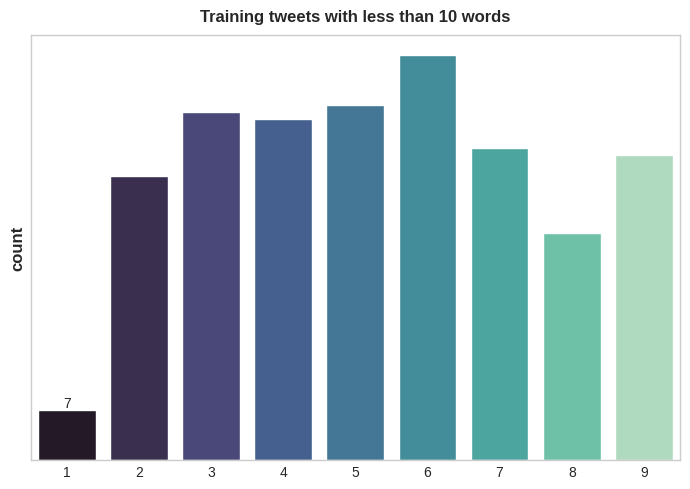

In [19]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

<ipython-input-20-7979c0899f38>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')


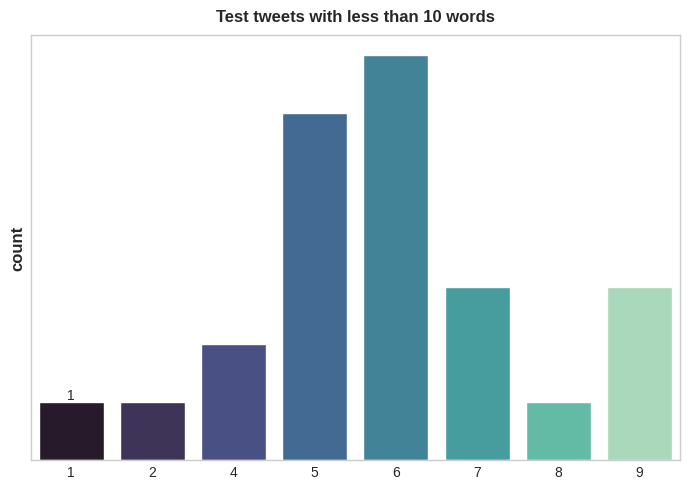

In [20]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [21]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (984, 3)
 DF TEST SHAPE: (60, 3)


In [22]:
df = df[df['text_len'] > 4]

In [23]:
df_test = df_test[df_test['text_len'] > 4]

In [24]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (840, 3)
 DF TEST SHAPE: (56, 3)


## Training data deeper cleaning

Let's perform a further cleaning checking the tokenizer version of the sentences.

First, we import the BERT tokenizer.

In [25]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
token_lens = []

for txt in df['Text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [27]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 78


Let's check the long tokenized sentences (with more than 80 tokens ):

In [28]:
token_lens = []

for i,txt in enumerate(df['Text'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

These sentences are not in english. They should be dropped.

In [29]:
df['token_lens'] = token_lens

In [30]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,Text,VADER_Sentiment,text_len,token_lens
199,apple music adobe bartleby brainly canva cours...,Positive,43,78
202,apple music adobe bartleby brainly canva cours...,Positive,43,78
206,apple music adobe bartleby brainly canva cours...,Positive,43,78
302,adobe apple music bartleby brainly canva cours...,Positive,43,77
203,apple music adobe bartleby brainly canva cours...,Positive,43,77
310,adobe apple music bartleby brainly canva cours...,Positive,43,77
5,premium account available prem canva pro netfl...,Positive,41,73
826,10 chrome extension enhance chatgpt smarter br...,Positive,37,63
21,panjang nak cerita ni man hahaha basically vis...,Positive,37,61
983,edtech world forum 2023 london nov 2021 book e...,Neutral,24,59


In [31]:
df = df.iloc[12:]
df.head()

,Text,VADER_Sentiment,text_len,token_lens
162,ai aiart art aiartcommunity nftart nftartist p...,Neutral,27,57
566,tuberank jeet 5 pro chatgpt plus v56 full acti...,Neutral,24,57
572,decide would cause confusion amongst public te...,Negative,26,54
308,friend download free audio review copy amp lea...,Positive,32,53
241,friend download free audio review copy amp lea...,Positive,32,53


The dataset looks more clean now. We will shuffle it and reset the index.

In [32]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data deeper cleaning

We will perform the data cleaning based on the tokenized sentences on the test set.

In [33]:
token_lens_test = []

for txt in df_test['Text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [34]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 41


In [35]:
token_lens_test = []

for i,txt in enumerate(df_test['Text'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [36]:
df_test['token_lens'] = token_lens_test

In [37]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,Text,Sentiment,text_len,token_lens
45,stack overflow lay 28 percent staff share meme...,Positive,21,41
50,z9vp1 ready attach front meeting work seat cha...,Positive,13,39
48,saw guy ask chatgpt roleplay amp pretend pickp...,Positive,27,39
42,great article peter greiff build autonomous ag...,Positive,26,38
14,fantom foundation hack incident raise question...,Neutral,21,37
28,nope didnt even open chatgpt osama bin laden o...,Negative,28,36
43,22 ai chatgpt others like gear towards quantif...,Positive,27,35
47,chatgpt robotic process automation rpa like di...,Positive,27,34
13,e main apart craze little thoughtful culture g...,Neutral,15,34
29,first time today use chatgpt catch syntax spel...,Negative,26,34


In [38]:
df_test = df_test.iloc[5:]
df_test.head(3)

,Text,Sentiment,text_len,token_lens
28,nope didnt even open chatgpt osama bin laden o...,Negative,28,36
43,22 ai chatgpt others like gear towards quantif...,Positive,27,35
47,chatgpt robotic process automation rpa like di...,Positive,27,34


In [39]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

Now the data cleaning is completed. I will perform more data cleaning if I have new ideas !! :)

# Sentiment column analysis

Now we will look at the target column 'Sentiment'.

In [40]:
df['VADER_Sentiment'].value_counts()

Positive    402
Neutral     298
Negative    128
Name: VADER_Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [41]:
df['VADER_Sentiment'] = df['VADER_Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [42]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [43]:
df['VADER_Sentiment'].value_counts()

2    402
1    298
0    128
Name: VADER_Sentiment, dtype: int64

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [44]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['Text']).reshape(-1, 1), np.array(df['VADER_Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['Text', 'VADER_Sentiment']);

In [45]:
train_os['VADER_Sentiment'].value_counts()

1    402
2    402
0    402
Name: VADER_Sentiment, dtype: int64

## Train - Validation - Test split

In [46]:
X = train_os['Text'].values
y = train_os['VADER_Sentiment'].values

A validation set will be extracted from the training set to monitor the validation accuracy, and so prevent overfitting.

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [48]:
X_test = df_test['Text'].values
y_test = df_test['Sentiment'].values

## One hot encoding

After performing some tests, by using one hot encoding on the target variable we achieved higher accuracy. For this reason we will choose one hot enconding over label encoding. <br>
EDIT: We will save a copy of the label encoded target columns since they could be useful for further analysis.

In [49]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [50]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [51]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 1085
VALIDATION DATA: 121
TESTING DATA: 51


In [52]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# RoBERTa Sentiment Analysis

As seen for BERT, we first import the tokenizer used to train the original roberta transformer by Facebook.

In [53]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

First, we check the length of the longest tokenized sentence by roberta tokenizer:

In [54]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

79

In [55]:
MAX_LEN=128

Then we can define the tokenization function

In [56]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [57]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

# RoBERTa modeling

In [58]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [59]:
roberta_model = TFRobertaModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [60]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [61]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

Epoch 1/4
37/37 [==============================] - 1756s 47s/step - loss: 0.8644 - categorical_accuracy: 0.6074 - val_loss: 0.7490 - val_categorical_accuracy: 0.6694
Epoch 2/4
37/37 [==============================] - 1700s 46s/step - loss: 0.5876 - categorical_accuracy: 0.7659 - val_loss: 0.6651 - val_categorical_accuracy: 0.7851
Epoch 3/4
37/37 [==============================] - 1684s 46s/step - loss: 0.4081 - categorical_accuracy: 0.8525 - val_loss: 0.6867 - val_categorical_accuracy: 0.7934
Epoch 4/4
37/37 [==============================] - 1688s 46s/step - loss: 0.3183 - categorical_accuracy: 0.8885 - val_loss: 0.7274 - val_categorical_accuracy: 0.7769


# RoBERTa results

In [62]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

2/2 [==============================] - 28s 8s/step


In [63]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [64]:
predicted_labels = np.argmax(result_roberta, axis=1)
accuracy = np.mean(y_pred_roberta == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.934640522875817


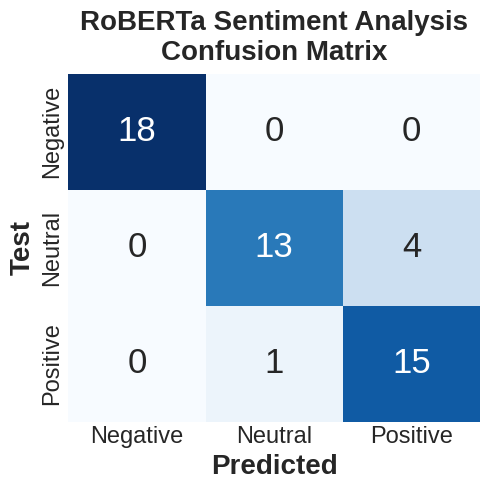

In [65]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [66]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        18
     Neutral       0.93      0.76      0.84        17
    Positive       0.79      0.94      0.86        16

   micro avg       0.90      0.90      0.90        51
   macro avg       0.91      0.90      0.90        51
weighted avg       0.91      0.90      0.90        51
 samples avg       0.90      0.90      0.90        51



# Results Summary

## RoBERTa Classification Report

In [67]:
print('Classification Report for RoBERTa:\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for RoBERTa:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        18
     Neutral       0.93      0.76      0.84        17
    Positive       0.79      0.94      0.86        16

   micro avg       0.90      0.90      0.90        51
   macro avg       0.91      0.90      0.90        51
weighted avg       0.91      0.90      0.90        51
 samples avg       0.90      0.90      0.90        51



## Classification Matrix Comparison

In [68]:
# Simpan model
roberta_model.save_pretrained("roberta_sentiment_model")

In [69]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import tensorflow as tf

# Load pre-trained model and tokenizer
model_name = "roberta_sentiment_model"
token = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(token)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, config=config)

# Define function to perform sentiment analysis
def sentiment_analysis(text):
    # Tokenize input text
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="tf")

    # Perform inference
    outputs = model(inputs)

    # Get predicted label
    predicted_label = tf.argmax(outputs.logits, axis=1).numpy()[0]

    # Convert label to sentiment
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = sentiment_mapping[predicted_label]

    return sentiment

# Example usage
text = "chatgpt is so bad"
sentiment = sentiment_analysis(text)
print("Sentiment:", sentiment)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta_sentiment_model and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentiment: Positive
